<a href="https://colab.research.google.com/github/myazdani/hacking-minGPT/blob/main/play_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/myazdani/hacking-minGPT.git

import sys
  
# adding Folder_2 to the system path
sys.path.insert(0, './hacking-minGPT/')

fatal: destination path 'hacking-minGPT' already exists and is not an empty directory.


In [2]:
## only needed if running on google colab
!wget https://raw.githubusercontent.com/myazdani/attention-layer-demo/master/utils.py

--2022-07-11 05:31:25--  https://raw.githubusercontent.com/myazdani/attention-layer-demo/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3583 (3.5K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]   3.50K  --.-KB/s    in 0s      

2022-07-11 05:31:25 (50.5 MB/s) - ‘utils.py.1’ saved [3583/3583]



In [3]:
import utils

data_gen = utils.DataUtil(seq_height_min = 1.0, 
                          seq_height_max = 25.0,
                          seq_width_min = 5.0, 
                          seq_width_max = 11.0,
                          seq_length = 100,
                          group_by_locations = False
                         )

In [4]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [5]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [6]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [7]:
train_input, train_targets, train_tr, train_bx = data_gen.generate_sequences(25000)
test_input, test_targets, test_tr, test_bx = data_gen.generate_sequences(1000)

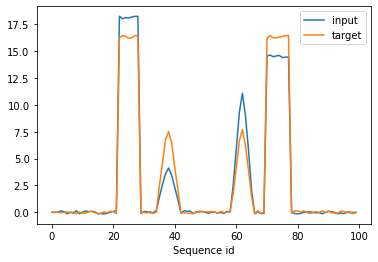

In [66]:
plt.plot(train_input[1,0,:], label = "input")
plt.plot(train_targets[1,0,:], label = "target")
plt.xlabel("Sequence id")
plt.legend();

### cluster the raw sequence values into discrete clusters

In [8]:
# get random 5 vals per seq and stack them all up 
pluck_vals = lambda x: x[0,torch.randperm(100)[:5]]
random_vals = torch.cat([pluck_vals(x) for x in train_input]).numpy()
print(random_vals.shape)

(125000,)


In [9]:
from sklearn.cluster import KMeans
import numpy as np
num_clusters = 256
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(random_vals[:,np.newaxis])
kmeans.labels_

array([216, 209, 255, ...,  71, 228,  96], dtype=int32)

In [10]:
from torch.utils.data import Dataset

class SeqDataset(Dataset):
    """
    wrap up seq dataset into our own, which will convert floating points into sequences of integers
    """
    
    def __init__(self, inputs, targets, kmeans_clusters):
        self.inputs = inputs
        self.targets = targets
        self.kmeans_clusters = kmeans_clusters
        
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x, y = self.inputs[idx], self.targets[idx]
        batch_size = x.shape[0]
        x_np = x.view(-1,1).numpy()
        y_np = y.view(-1,1).numpy()
        x_clusters = torch.from_numpy(self.kmeans_clusters.predict(x_np)).view(batch_size,-1).long()
        y_clusters = torch.from_numpy(self.kmeans_clusters.predict(y_np)).view(batch_size,-1).long()

        return x_clusters.squeeze(), y_clusters.squeeze()

In [11]:
train_dataset = SeqDataset(train_input, train_targets, kmeans)
test_dataset = SeqDataset(test_input, test_targets, kmeans)
train_dataset[0][0] # one example sequence flattened out into integers

tensor([ 80, 117,  49, 246,  32, 124, 255,  80, 178,   0, 117, 216, 117,   0,
          0, 228, 156,  95, 241,  95, 156, 241,  96, 246, 206,   5,  77, 191,
        163, 106, 115, 170, 113, 232, 231, 176,  96, 178, 216,  80,  80, 110,
         86,  50, 159, 137, 148, 144, 188,  75, 255,  32, 176,  32, 117, 180,
         32, 216,  71,  49,  14,  80, 255, 178,   0,  80, 255, 178,  83, 209,
         83, 223, 209, 133, 133, 124, 216, 246, 228, 167, 178, 176,  14, 216,
        180, 180,  71, 178,  71,  49, 167, 176,  49,  14, 117,  96, 117,  49,
         14, 246])

In [12]:
from mingpt.model import GPT, GPTConfig
block_size = 100
mconf = GPTConfig(num_clusters, block_size,
                  n_layer=2, n_head=4, n_embd=128)
model = GPT(mconf)

07/11/2022 05:32:08 - INFO - mingpt.model -   number of parameters: 4.751360e+05


In [13]:
from mingpt.trainer import Trainer, TrainerConfig

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=10, batch_size=128, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*block_size,
                      num_workers=4)
trainer = Trainer(model, train_dataset, None, tconf)
trainer.train()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch 1 iter 195: train loss 3.58380. lr 3.009671e-04: 100%|██████████| 196/196 [00:18<00:00, 10.43it/s]
epoch 2 iter 195: train loss 3.49141. lr 6.000000e-05: 100%|██████████| 196/196 [00:18<00:00, 10.41it/s]
epoch 3 iter 195: train loss 3.47218. lr 3.009671e-04: 100%|██████████| 196/196 [00:19<00:00,  9.93it/s]
epoch 4 iter 195: train loss 3.43543. lr 5.999938e-04: 100%|██████████| 196/196 [00:19<00:00,  9.81it/s]
epoch 5 iter 195: train loss 3.38589. lr 2.970988e-04: 100%|██████████| 196/196 [00:18<00:00, 10.38it/s]
epoch 6 iter 195: t

In [14]:
train_dataset[0][0].view(1,-1).size()

torch.Size([1, 100])

In [18]:
pred = model(train_dataset[0][0].view(1,-1).cuda())

In [19]:
import matplotlib.pyplot as plt

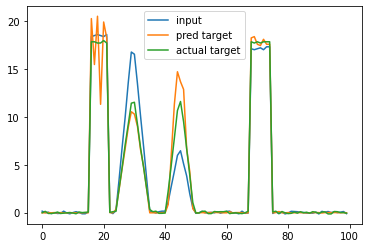

In [27]:
plt.plot(kmeans.cluster_centers_[:,0][train_dataset[0][0].cpu().numpy()], label = 'input')
plt.plot(kmeans.cluster_centers_[:,0][pred[0].argmax(axis=2).cpu().numpy().squeeze()], label = 'pred target')
plt.plot(kmeans.cluster_centers_[:,0][train_dataset[0][1].cpu().numpy()], label = 'actual target')
plt.legend();

In [28]:
pred = model(test_dataset[0][0].view(1,-1).cuda())

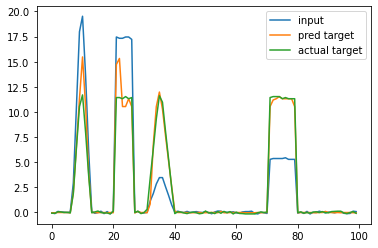

In [29]:
plt.plot(kmeans.cluster_centers_[:,0][test_dataset[0][0].cpu().numpy()], label = 'input')
plt.plot(kmeans.cluster_centers_[:,0][pred[0].argmax(axis=2).cpu().numpy().squeeze()], label = 'pred target')
plt.plot(kmeans.cluster_centers_[:,0][test_dataset[0][1].cpu().numpy()], label = 'actual target')
plt.legend();